<a href="https://colab.research.google.com/github/chavgova/My-AI/blob/master/emotion_recognition_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORT

In [58]:
#this is the copy of another projecct and ill make changes to see how i can make it better 
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras import regularizers
import os

In [59]:
from google.colab import drive
import os

path = '/content/drive/My Drive/My_AI/RawData'

mylist = []

#for root, directories, files in os.walk(path, topdown=False):
#	for name in files:
#			#print(os.path.join(root, name))
#			mylist.append(name)

mylist = os.listdir(path)

print(mylist)	



['03-01-02-01-01-02-16.wav', '03-01-07-02-01-02-15.wav', '03-01-08-01-02-01-15.wav', '03-01-03-01-02-01-16.wav', '03-01-08-02-01-02-15.wav', '03-01-02-01-02-01-16.wav', '03-01-02-01-02-02-16.wav', '03-01-07-02-02-01-15.wav', '03-01-07-01-02-02-15.wav', '03-01-08-01-01-02-15.wav', '03-01-03-01-01-02-16.wav', '03-01-03-01-01-01-16.wav', '03-01-02-02-01-02-16.wav', '03-01-08-01-02-02-15.wav', '03-01-02-02-02-02-16.wav', '03-01-08-02-01-01-15.wav', '03-01-01-01-02-01-16.wav', '03-01-07-02-01-01-15.wav', '03-01-02-02-02-01-16.wav', '03-01-01-01-01-01-16.wav', '03-01-08-02-02-02-15.wav', '03-01-02-02-01-01-16.wav', '03-01-06-02-01-02-15.wav', '03-01-08-02-02-01-15.wav', '03-01-01-01-01-02-16.wav', '03-01-01-01-02-02-16.wav', '03-01-06-02-02-02-15.wav', '03-01-08-01-01-01-15.wav', '03-01-02-01-01-01-16.wav', '03-01-07-01-01-01-15.wav', '03-01-07-02-02-02-15.wav', '03-01-06-02-02-01-15.wav', '03-01-07-01-02-01-15.wav', '03-01-05-02-02-01-16.wav', '03-01-04-01-01-02-16.wav', '03-01-06-01-01-02-

In [60]:
print(mylist[50])

03-01-06-01-02-01-16.wav


In [61]:
print(mylist[18][6:-16])

02


LABLES

In [62]:
feeling_list=[]
for item in mylist:
    if int(item[18:-4])%2==0:  #female
        if item[6:-16]=='01':
          feeling_list.append('female_neutral')
        elif item[6:-16]=='02':
          feeling_list.append('female_calm')
        elif item[6:-16]=='03':
          feeling_list.append('female_happy')
        elif item[6:-16]=='04':
          feeling_list.append('female_sad')
        elif item[6:-16]=='05':
          feeling_list.append('female_angry')
        elif item[6:-16]=='06':
          feeling_list.append('female_fearful')
        elif item[6:-16]=='07':
          feeling_list.append('female_disgust')
        elif item[6:-16]=='08':
          feeling_list.append('female_surprised')
    else:
      if item[6:-16]=='01':
        feeling_list.append('male_neutral')
      elif item[6:-16]=='02':
        feeling_list.append('male_calm')
      elif item[6:-16]=='03':
        feeling_list.append('male_happy')
      elif item[6:-16]=='04':
        feeling_list.append('male_sad')
      elif item[6:-16]=='05':
        feeling_list.append('male_angry')
      elif item[6:-16]=='06':
        feeling_list.append('male_fearful')
      elif item[6:-16]=='07':
        feeling_list.append('male_disgust')
      elif item[6:-16]=='08':
        feeling_list.append('male_surprised')


In [63]:
import pandas as pd

labels = pd.DataFrame(feeling_list)
labels[:10]      #print

,0
0,female_calm
1,male_disgust
2,male_surprised
3,female_happy
4,male_surprised
5,female_calm
6,female_calm
7,male_disgust
8,male_disgust
9,male_surprised


Getting the features of audio files using librosa

In [64]:
import librosa
import numpy as np

def extract_feature(my_file, **kwargs):
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(my_file)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))

    return result

f = os.fspath('/content/drive/My Drive/My_AI/RawData/03-01-08-01-01-02-01.wav')
a = extract_feature(f, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
#print(a, a.shape)

In [65]:
df = pd.DataFrame(columns=['all_features'])
bookmark=0

#mylist = mylist[:100]
for index,y in enumerate(mylist):
      #sample_rate = np.array(sample_rate)
      all_features_ndarray = extract_feature('/content/drive/My Drive/My_AI/RawData/'+y, mel=True, mfcc=True, contrast=True, chroma=True, tonnetz=True)
      df.loc[bookmark] = [all_features_ndarray]
      bookmark=bookmark+1
        
#df[:5]    #print 


In [66]:
df3 = pd.DataFrame(df['all_features'].values.tolist())

In [67]:
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})
rnewdf[:10]     #print

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
0,-647.855547,55.161974,6.022664,11.279636,1.494477,-10.823069,-9.768314,-3.426524,-5.141561,-3.937714,-9.222471,-2.322059,-3.491471,-3.229235,-2.588595,-6.148681,-4.438408,-3.765655,-6.711987,-2.241300,-5.629476,-3.342788,-5.519323,-2.143104,-3.962271,0.580401,-0.845263,0.836235,-1.663852,0.103594,-1.442232,2.398137,1.210933,1.309208,-1.149667,0.796317,-0.387185,1.851878,1.965089,2.852826,...,0.000028,0.000056,0.000062,0.000073,0.000086,0.000148,0.000405,0.000204,0.000275,0.000194,0.000097,0.000089,0.000097,0.000078,0.000133,0.000146,0.000158,0.000236,0.000160,0.000115,0.000124,0.000239,0.000243,0.000193,0.000037,4.089572e-06,19.825734,17.413286,18.683788,17.631371,17.597609,17.479021,27.669175,0.008979,0.002485,-0.011113,0.007860,-0.022812,0.010703,female_calm
1,-563.963067,84.188943,-3.152482,14.670623,14.059518,1.252880,0.042044,-4.397226,-4.238579,4.932143,4.076926,4.698377,2.391880,3.431389,2.035749,4.756171,2.224375,1.005362,4.411248,3.984690,-0.575655,5.080584,1.983271,6.256003,0.638210,3.379015,1.574879,5.086869,-0.242717,3.516233,2.506099,4.326962,3.277128,3.450532,1.574356,5.171896,1.693470,1.381288,0.377714,0.676257,...,0.000131,0.000161,0.000127,0.000110,0.000103,0.000081,0.000054,0.000073,0.000041,0.000052,0.000044,0.000038,0.000035,0.000044,0.000065,0.000059,0.000042,0.000044,0.000062,0.000066,0.000068,0.000047,0.000039,0.000038,0.000023,2.302145e-06,23.765040,14.047504,17.620982,16.756985,18.187620,18.827449,29.978436,-0.033824,0.031722,-0.020895,0.045294,0.001301,0.021214,male_disgust
2,-594.637783,67.321998,-8.268769,11.827235,11.677641,-2.248863,-0.757726,-1.896019,-6.689641,2.705992,1.314382,1.545111,-2.906595,1.502054,2.958313,1.123918,0.773195,-2.079359,-0.045413,-0.557165,-4.386110,0.844472,-1.391011,-0.348034,-2.591043,2.353713,-1.338228,2.886713,-1.977508,3.363003,1.152010,1.973229,0.534796,1.680699,-0.927337,2.229836,-1.213668,0.681434,-0.775523,-0.460335,...,0.000236,0.000162,0.000102,0.000152,0.000227,0.000257,0.000131,0.000087,0.000106,0.000106,0.000104,0.000086,0.000044,0.000047,0.000054,0.000035,0.000028,0.000023,0.000019,0.000029,0.000032,0.000036,0.000037,0.000031,0.000011,7.863616e-07,19.929019,14.123903,15.800768,15.526285,16.498655,18.605405,29.240658,-0.004248,0.026129,-0.065590,-0.075824,0.024136,0.000908,male_surprised
3,-579.891136,42.039627,-5.053938,7.798847,-0.126285,-9.143354,-12.422559,-8.201250,-6.497337,-1.633368,-9.284363,-4.746703,-2.252793,-5.042223,-4.782923,-4.012217,-5.518520,-4.907112,-4.995540,-4.075550,-5.216173,-5.194875,-4.929390,-4.127506,-6.202564,-0.801092,-1.592606,2.628457,-0.227953,1.161160,-3.117599,-1.825591,-3.542235,-0.268574,0.695758,5.276096,4.330442,3.046888,0.705429,0.176194,...,0.000343,0.000465,0.000726,0.000588,0.000524,0.000399,0.000546,0.000814,0.000702,0.000639,0.000532,0.001084,0.000709,0.000725,0.000817,0.000606,0.000388,0.000592,0.001056,0.001199,0.001075,0.001202,0.000646,0.000797,0.000216,8.414706e-06,21.887936,17.434534,18.300346,15.796353,16.286331,17.025731,29.803272,0.004377,0.022846,0.011245,0.010188,0.004092,0.014409,female_happy
4,-565.406756,62.303829,-5.321900,18.836435,15.299373,-2.065662,2.862254,1.808206,-3.145949,5.947861,2.749695,1.463870,0.905952,4.024624,3.162084,2.127669,2.406441,-2.238956,1.615928,2.867413,-2.066120,3.500315,-0.105012,3.404132,-0.740987,2.726745,-1.422287,2.922709,-1.661077,2.871916,1.522402,1.949224,0.923216,0.273763,-0.487322,2.254013,0.374031,2.177778,1.066371,1.301072,...,0.000052,0.000075,0.000091,0.000066,0.000046,0.000037,0.000070,0.000070,0.000065,0.000086,0.000108,0.000078,0.000063,0.000041,0.000030,0.000023,0.000021,0.000036,0.000049,0.000060,0.000055,0.000069,0.000078,0.000042,0.000021,1.715290e-06,21.130542,12.441178,15.138805,14.4

In [68]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]      #print 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
586,-481.126323,57.019168,-17.853669,2.807965,7.161006,-12.487418,-15.399348,-7.598967,-14.853569,-1.557878,-1.650752,-4.206447,-5.271166,2.559451,-7.262202,1.496056,-4.291542,-5.075465,-2.947257,-2.253577,-5.725189,-6.636879,-6.148405,-3.226614,-4.587646,4.157474,3.889398,9.195774,7.799599,5.980804,5.354587,4.294531,1.031854,3.552179,2.915256,4.188196,2.861108,3.488739,0.924470,1.560746,...,0.000690,0.000546,6.062237e-04,5.255787e-04,4.640333e-04,9.636337e-04,1.078093e-03,8.478192e-04,5.243984e-04,4.918505e-04,4.977691e-04,4.910106e-04,4.406926e-04,4.427186e-04,5.553504e-04,5.357209e-04,4.804507e-04,3.901605e-04,3.767910e-04,3.501002e-04,2.164408e-04,2.362665e-04,1.399582e-04,5.674581e-05,1.635482e-05,1.151686e-06,20.119174,15.253152,19.140629,17.627812,19.176578,19.856898,32.102449,0.003763,0.004470,-0.012100,0.005489,0.002630,-0.001087,male_happy
1115,-455.350797,43.614218,-9.983114,7.356654,-2.801902,-6.846382,-7.934692,-8.815881,-0.494995,-8.247132,-2.174223,1.015188,-7.691178,0.146477,-3.123569,-3.141704,-5.527254,-3.125459,-4.316515,-2.443707,-7.690322,-2.204108,-1.076610,-2.120160,-0.581912,3.592511,0.080330,3.685900,3.589440,3.999512,-0.682340,2.345977,-1.063009,2.168404,2.632378,3.317173,0.642624,1.674246,0.203572,1.814110,...,0.000740,0.000853,1.113115e-03,1.082536e-03,6.736268e-04,6.853423e-04,1.103442e-03,9.944827e-04,9.051486e-04,3.569745e-04,2.455394e-04,4.455874e-04,5.031379e-04,5.466301e-04,5.156854e-04,6.626249e-04,7.693327e-04,1.106903e-03,9.761733e-04,7.495700e-04,7.724580e-04,8.103435e-04,9.525406e-04,5.935777e-04,2.061034e-04,1.609871e-05,17.190653,12.973365,15.740933,15.288178,16.150696,16.587392,28.038516,-0.005538,0.009250,-0.015384,-0.023010,0.005985,-0.000798,male_surprised
579,-660.728256,74.947106,-0.507048,21.758795,11.251092,-4.256695,-2.484361,0.891266,-4.311981,-3.607514,-3.862001,-3.542882,0.907845,-1.466995,-5.494954,1.740395,-1.009175,-1.669656,-2.979835,0.397866,-3.324130,-1.359299,-4.612190,-1.036602,-1.712286,-1.003408,-3.846482,0.427500,-2.339012,-0.399797,-2.924710,1.162085,-2.629173,1.022438,-2.423351,0.792297,-2.054616,-0.899553,-3.626119,-0.925675,...,0.000078,0.000038,4.210887e-05,3.534835e-05,2.360905e-05,1.634445e-05,1.125157e-05,7.795151e-06,6.615004e-06,6.599230e-06,6.404894e-06,5.873238e-06,8.757853e-06,1.388300e-05,1.468211e-05,1.820970e-05,1.934105e-05,1.193099e-05,8.161615e-06,1.014082e-05,1.411935e-05,1.511253e-05,7.703181e-06,4.832237e-06,2.303663e-06,2.902299e-07,16.512303,12.353352,14.956431,14.592036,15.730845,16.805576,29.324699,-0.001028,0.006221,-0.024005,-0.038553,-0.002942,-0.004379,male_disgust
395,-601.553437,48.985692,-3.507863,7.149540,7.276663,-2.794190,-3.027216,-7.463704,-9.859744,-2.872128,-1.936478,-2.859597,-3.200600,-0.710558,-4.378930,1.048447,-5.192461,-0.501107,-2.698245,-2.387129,-4.787263,-2.459462,-1.629121,-3.010623,-3.346290,-0.471533,-4.575351,-0.558994,-3.204156,-2.090788,-3.236015,-0.639333,-4.210067,-1.733351,-2.826730,-0.448337,-1.039234,0.409701,-1.650840,-1.187951,...,0.000526,0.000489,3.644236e-04,2.360083e-04,1.796311e-04,2.909416e-04,2.172264e-04,1.052908e-04,9.092845e-05,8.717617e-05,1.252422e-04,1.519268e-04,3.036405e-04,4.244107e-04,2.480868e-04,2.045211e-04,2.928921e-04,2.332445e-04,1.238992e-04,1.891227e-04,1.594676e-04,8.838078e-05,5.391456e-05,1.084726e-04,7.428665e-05,6.566989e-06,21.045687,13.209464,15.870391,14.234502,15.717311,16.452730,28.209016,-0.005092,0.024311,-0.005760,-0.018712,-0.000451,0.013465,male_fearful
543,-664.817728,77.131401,0.960087,16.091147,18.618794,0.636154,-4.454123,-3.744590,-2.759126,3.647947,-2.270012,-1.351634,-1.260715,3.429134,-1.333814,1.306954,0.771175,0.766637,-4.595420,3.586233,-2.694093,-1.223791,-3.223852,0.158700,-2.078288

In [69]:
rnewdf=rnewdf.fillna(0)


Dividing the data into test and train

In [70]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [71]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,0
14,-665.136264,49.823534,5.048578,5.156823,0.539535,-10.366421,-15.286416,-4.979676,-7.756437,-1.575055,-9.077134,-2.592485,-2.222924,-6.178970,-2.908575,-4.109085,-5.368557,-3.279212,-6.500448,-3.103513,-6.104930,-3.638738,-4.541355,-4.595115,-5.936765,-3.197077,-2.878061,-3.261826,-4.622773,-4.159825,-5.299934,-2.403368,-2.480212,1.172361,2.555748,5.127642,1.877846,1.546061,-1.410552,1.177284,...,0.000138,0.000195,0.000347,0.000367,0.000497,0.001338,0.000953,0.000947,0.001128,0.001745,0.001975,0.001189,0.000707,0.000678,0.000689,0.000701,0.000834,0.001062,0.000774,0.000422,0.000420,0.000252,0.000202,0.000225,0.000114,7.828024e-06,21.754185,15.175208,16.937619,16.353576,16.615379,16.049946,28.552989,-0.004031,0.017678,0.049412,0.009100,-2.609255e-03,0.004923,female_calm
329,-679.962480,48.585882,-1.811615,7.977092,4.554720,-1.406997,-6.186258,-7.186865,-9.217459,-0.727058,-1.466770,-6.447651,-0.124691,-1.311730,1.110713,-6.281726,-3.029058,-2.392617,-5.276442,-2.953819,-4.565116,-1.302752,-4.519165,2.563915,-1.690809,2.324500,0.223102,1.455359,-0.679264,1.649048,-1.207601,-0.329546,-0.974849,1.738930,2.232344,3.924775,1.313777,2.219237,-1.821621,0.614140,...,0.000028,0.000031,0.000020,0.000059,0.000046,0.000039,0.000081,0.000114,0.000103,0.000055,0.000024,0.000020,0.000030,0.000015,0.000012,0.000036,0.000020,0.000013,0.000016,0.000021,0.000032,0.000029,0.000015,0.000013,0.000004,2.733873e-07,19.828195,14.800833,16.596140,16.138725,16.785402,16.369423,28.931057,-0.001693,0.017865,0.037137,0.004642,1.295393e-02,0.005817,female_calm
739,-673.170605,50.369332,-0.924144,8.985247,3.424835,-3.889490,-5.821972,-11.637133,-8.507535,-4.070089,-8.166125,-2.923064,-11.398255,-2.564710,-1.396298,-8.268705,-7.925904,-1.888177,-3.810996,-3.928674,-4.352340,-1.441531,-4.930890,-2.855820,-2.495678,1.874143,0.076237,5.067771,0.682102,6.273457,0.598943,1.823691,0.619852,3.471256,6.122504,6.687379,5.894958,5.611837,0.694228,-0.024472,...,0.000023,0.000044,0.000050,0.000072,0.000105,0.000077,0.000051,0.000036,0.000030,0.000057,0.000084,0.000167,0.000122,0.000091,0.000066,0.000131,0.000251,0.000203,0.000138,0.000117,0.000231,0.000263,0.000375,0.000310,0.000090,7.804152e-06,21.095605,17.321213,17.760438,16.113838,17.119259,17.039798,29.816407,-0.004121,0.005370,0.045303,-0.044162,9.462370e-03,-0.001095,female_calm
636,-589.458526,51.280376,5.963789,9.209922,4.653793,0.087882,-4.800388,-12.067040,0.386346,3.246700,-6.095488,-3.703840,0.516757,-1.209141,0.787437,0.291697,-3.734274,-0.439044,-1.386193,-7.794902,-2.832901,-1.640612,-5.497535,-1.186287,-4.470901,0.562387,-4.333657,3.772316,4.614838,6.959103,7.620317,4.853884,4.623564,5.398815,6.466361,3.998223,3.172853,1.583046,0.625894,2.290244,...,0.001487,0.001559,0.001593,0.001388,0.000849,0.000342,0.000172,0.000276,0.000389,0.000708,0.001342,0.001651,0.002151,0.000739,0.000268,0.000320,0.000645,0.000525,0.000597,0.000365,0.000316,0.000329,0.000414,0.000384,0.000127,9.035850e-06,19.583430,16.210745,17.899402,16.045963,17.510789,17.576198,27.802642,-0.004334,0.011066,-0.023991,0.004618,7.062814e-03,-0.007349,female_fearful
122,-542.837063,39.177669,9.739320,10.265968,4.356870,6.867115,-2.536056,-5.060706,-6.073534,5.878630,-3.348387,-2.042405,2.482565,-2.088071,0.003241,-0.795033,-1.890737,-2.298676,-0.843736,-1.027719,-4.820625,1.518608,-3.480361,0.438265,-0.324111,3.982646,3.359665,4.980958,2.151355,4.309573,2.402673,3.269047,2.174008,3.348252,-0.021866,1.953640,1.236031,1.781985,-0.378672,0.803326,...,0.002579,0.002379,0.004278,0.004929,0.005606,0.007898,0.005848,0.008582,0.009346,0.010085,0.005740,0.003313,0.002489,0.001778,0.001015,0.000569,0.000439,0.000435,0.000370,0.000370,0.000361,0.000347,0.000399,0.000300,0.000100,8.59339

In [72]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]

In [73]:
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [74]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [75]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [76]:
X_train.shape

(1050, 193)

Changing dimension for CNN model

In [77]:
x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)
print(x_testcnn)

[[[-6.30158300e+02]
  [ 6.90582727e+01]
  [ 1.28152167e+01]
  ...
  [-1.08511395e-02]
  [ 1.38853939e-02]
  [ 1.73222135e-02]]

 [[-7.27243307e+02]
  [ 6.93527194e+01]
  [ 2.18346916e+01]
  ...
  [-4.04420141e-02]
  [-4.26833625e-03]
  [ 6.02592374e-03]]

 [[-6.71706925e+02]
  [ 4.75939919e+01]
  [ 5.30628227e+00]
  ...
  [-4.05363281e-02]
  [-2.93664871e-04]
  [-5.23372442e-03]]

 ...

 [[-7.01112208e+02]
  [ 6.64437802e+01]
  [ 2.75441773e+01]
  ...
  [-3.53023320e-02]
  [ 1.46736096e-03]
  [ 4.79008020e-03]]

 [[-4.54945861e+02]
  [ 3.85651873e+01]
  [-1.54543358e+01]
  ...
  [-2.08953104e-02]
  [ 5.55199547e-04]
  [-6.86884427e-03]]

 [[-7.27322834e+02]
  [ 6.64556534e+01]
  [ 1.30853698e+01]
  ...
  [ 2.51826220e-02]
  [ 5.41195997e-03]
  [ 8.60079461e-03]]]


In [78]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(193,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))

model.add(Flatten())

model.add(Dense(16))
model.add(Activation('softmax'))


opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)

In [79]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_12 (Conv1D)           (None, 193, 256)          1536      
_________________________________________________________________
activation_15 (Activation)   (None, 193, 256)          0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 193, 128)          163968    
_________________________________________________________________
activation_16 (Activation)   (None, 193, 128)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 193, 128)          0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 24, 128)           0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 24, 128)          

In [80]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

Removed the whole training part for avoiding unnecessary long epochs list

In [81]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=32, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
33/33 [==============================] - 6s 185ms/step - loss: 3.1142 - accuracy: 0.0514 - val_loss: 2.7796 - val_accuracy: 0.0954
Epoch 2/200
33/33 [==============================] - 6s 179ms/step - loss: 2.8166 - accuracy: 0.0724 - val_loss: 2.7303 - val_accuracy: 0.0878
Epoch 3/200
33/33 [==============================] - 6s 180ms/step - loss: 2.7529 - accuracy: 0.1000 - val_loss: 2.7180 - val_accuracy: 0.1260
Epoch 4/200
33/33 [==============================] - 6s 181ms/step - loss: 2.7184 - accuracy: 0.1152 - val_loss: 2.6887 - val_accuracy: 0.1260
Epoch 5/200
33/33 [==============================] - 6s 180ms/step - loss: 2.7249 - accuracy: 0.0886 - val_loss: 2.6732 - val_accuracy: 0.1374
Epoch 6/200
33/33 [==============================] - 6s 180ms/step - loss: 2.7054 - accuracy: 0.1295 - val_loss: 2.6583 - val_accuracy: 0.1374
Epoch 7/200
33/33 [==============================] - 6s 180ms/step - loss: 2.6791 - accuracy: 0.1400 - val_loss: 2.6411 - val_accuracy: 0.2023

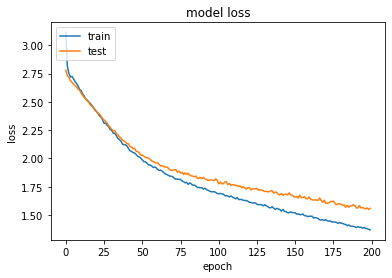

In [82]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()